In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

In [164]:
import seaborn as sns

In [3]:
#Format days of the week to not appear alphabetically on visuals
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

In [4]:
# Source: http://web.mta.info/developers/turnstile.html
df1 = pd.concat(map(pd.read_csv, (['http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt'])),ignore_index=True)

In [97]:
#Convert Date and Time into a more useable DateTime format.
def df_DateTime(df):
    df['DateTime'] = pd.to_datetime(df.DATE+' '+df.TIME)
    return df

#Record what day of the week each entry is from
def df_day_of_week(df):
    df['Day']=df.DateTime.dt.day_name()
    return df

#SCP represents a specific turnstile.
#C/A represents a control area. This is a bank of turnstiles.  
#Unit represents a remote unit. Usually a whole station, or an area in a complex station.
#We can combine all three to create a unique ID for any turnstile
def df_Unit_ID(df):
    df['Unit_ID'] = df.SCP+' '+df['C/A']+' '+df.UNIT
    return df

#Many station names appear unique, but are actually different locations. To give stations a unique identifier:
#Combine Station name, Division, and Linename
def df_station_id(df):
    df['station_id'] = df.STATION+' '+df.DIVISION+' '+df.LINENAME
    return df

#Rename Exits column to remove extra spaces
def rename_columns(df):
    df.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)
    return df

#Remove irregularities in reporting
def clean_desc(df):
    df = df[df.DESC == 'REGULAR']
    return df

#Calculate the entries/exits in a four hour period by finding the difference between rows
def df_four_hour(df):
    df['Four Hour Entries'] = df.groupby('Unit_ID').ENTRIES.diff()
    df['Four Hour Exits'] = df.groupby('Unit_ID').EXITS.diff()
    return df

#Replace NaN, negative values, and impossibly large values by the average of the turnstile
def df_clean_four_hour(df):
    df['Four Hour Entries'].fillna(-1, inplace=True)
    df['Four Hour Exits'].fillna(-1, inplace=True)
    df['Four Hour Entries'] = df.groupby(['TIME','C/A'])['Four Hour Entries'].transform(
        lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    df['Four Hour Exits'] = df.groupby(['TIME','C/A'])['Four Hour Exits'].transform(
        lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    return df

#Create a column for the total amount of traffic through a turnstile
def df_total_flow(df):
    df['Total Flow'] = df['Four Hour Entries']+df['Four Hour Exits']
    return df

In [6]:
df1 = df_DateTime(df1)
df1 = df_day_of_week(df1)
df1 = df_Unit_ID(df1)
df1 = rename_columns(df1)
df1 = df_four_hour(df1)
df1 = df_clean_four_hour(df1)
df1 = clean_desc(df1)
df1 = df_total_flow(df1)
df1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,Day,Unit_ID,Four Hour Entries,Four Hour Exits,Total Flow
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00,Saturday,02-00-00 A002 R051,150.529703,48.537129,199.066832
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00,Saturday,02-00-00 A002 R051,20.000000,7.000000,27.000000
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00,Saturday,02-00-00 A002 R051,23.000000,35.000000,58.000000
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00,Saturday,02-00-00 A002 R051,100.000000,76.000000,176.000000
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00,Saturday,02-00-00 A002 R051,259.000000,69.000000,328.000000


In [143]:
df1 = df_total_flow(df1)

In [218]:
day_flow = df1.groupby(['Day'])['Total Flow'].sum().reindex(cats)/1000000
day_flow.round(1)

Day
Monday       45.4
Tuesday      52.7
Wednesday    54.0
Thursday     53.9
Friday       53.5
Saturday     31.9
Sunday       24.7
Name: Total Flow, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

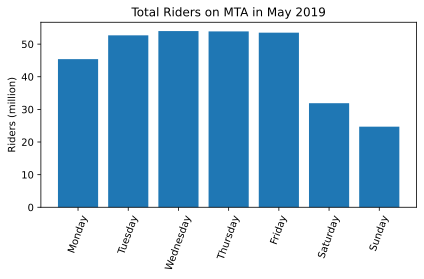

In [233]:
plt.bar(cats,day_flow.round(1))
plt.xticks(cats,rotation=70)
plt.title('Total Riders on MTA in May 2019')
plt.ylabel('Riders (million)')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_riders_days_of_week.svg',kind='svg')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

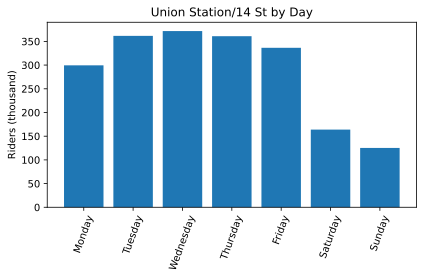

In [276]:
unionsq_days = df1.loc[df1['STATION']=='14 ST-UNION SQ'].groupby('Day')['Total Flow'].sum().reindex(cats)/1000
plt.bar(cats,union_days.round(1))
plt.xticks(cats,rotation=70)
plt.title('Union Station/14 St by Day')
plt.ylabel('Riders (thousand)')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\whatswrong.svg',kind='svg')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

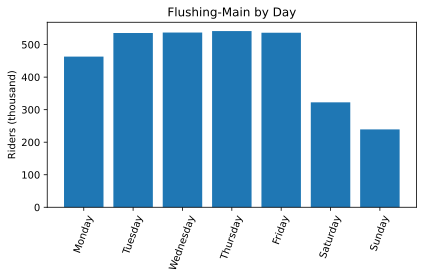

In [250]:
flushing_days = df1.loc[df1['STATION']=='FLUSHING-MAIN'].groupby('Day')['Total Flow'].sum().reindex(cats)/1000
plt.bar(cats,flushing_days.round(1))
plt.xticks(cats,rotation=70)
plt.title('Flushing-Main by Day')
plt.ylabel('Riders (thousand)')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\wflushing.svg',kind='svg')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

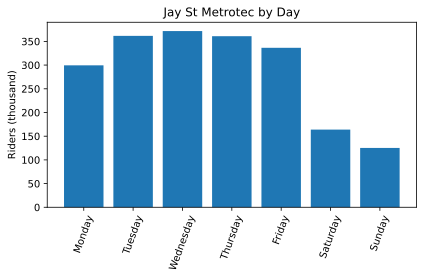

In [249]:
jayst_days = df1.loc[df1['STATION']=='JAY ST-METROTEC'].groupby('Day')['Total Flow'].sum().reindex(cats)/1000
plt.bar(cats,jayst_days.round(1))
plt.xticks(cats,rotation=70)
plt.title('Jay St Metrotec by Day')
plt.ylabel('Riders (thousand)')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\jayst_metrotec.svg',kind='svg')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

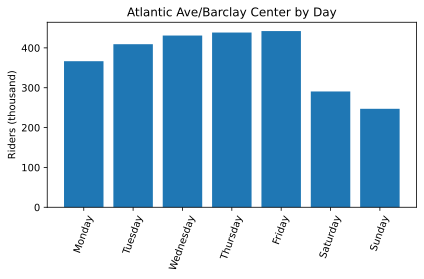

In [248]:
barclay_days = df1.loc[df1['STATION']=='ATL AV-BARCLAY'].groupby('Day')['Total Flow'].sum().reindex(cats)/1000
plt.bar(cats,barclay_days.round(1))
plt.xticks(cats,rotation=70)
plt.title('Atlantic Ave/Barclay Center by Day')
plt.ylabel('Riders (thousand)')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\w_atlanicbarclay.svg',kind='svg')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

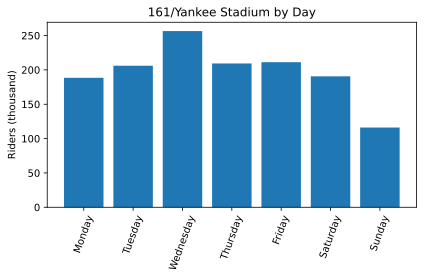

In [247]:
yankee_days = df1.loc[df1['STATION']=='161/YANKEE STAD'].groupby('Day')['Total Flow'].sum().reindex(cats)/1000
plt.bar(cats,yankee_days.round(1))
plt.xticks(cats,rotation=70)
plt.title('161/Yankee Stadium by Day')
plt.ylabel('Riders (thousand)')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\yankee.svg',kind='svg')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

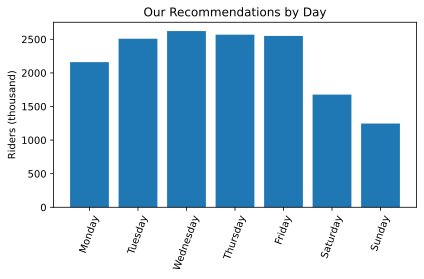

In [252]:
recommendation_days = df1.loc[(df1['STATION']=='161/YANKEE STAD')|
                             (df1['STATION']=='ATL AV-BARCLAY') |
                             (df1['STATION']=='JAY ST-METROTEC') |
                             (df1['STATION']=='14 ST-UNION SQ') |
                             (df1['STATION']=='FLUSHING-MAIN') 
                             ].groupby('Day')['Total Flow'].sum().reindex(cats)/1000
plt.bar(cats,recommendation_days.round(1))
plt.xticks(cats,rotation=70)
plt.title('Our Recommendations by Day')
plt.ylabel('Riders (thousand)')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\wrecommendations.svg',kind='svg')
plt.show

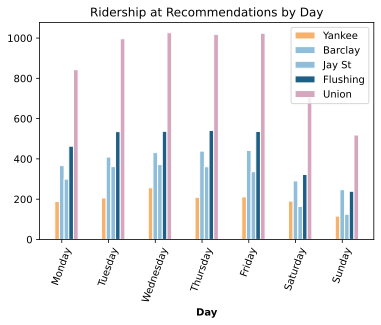

In [305]:
#All graphs by days - Bar Graph

barWidth = 0.1
 
# set height of bar
bars1 = yankee_days
bars2 = barclay_days
bars3 = jayst_days
bars4 = flushing_days
bars5 = unionsq_days


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, bars1, color='#f6b26bff', width=barWidth, edgecolor='white', label='Yankee')
plt.bar(r2, bars2, color='#8ebed9ff', width=barWidth, edgecolor='white', label='Barclay')
plt.bar(r3, bars3, color='#8ebed9ff', width=barWidth, edgecolor='white', label='Jay St')
plt.bar(r4, bars4, color='#1e5f85ff', width=barWidth, edgecolor='white', label='Flushing')
plt.bar(r5, bars5, color='#d5a6bdff', width=barWidth, edgecolor='white', label='Union')

 
# Add xticks on the middle of the group bars
plt.xlabel('Day', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], cats, rotation=70)
 
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\multi_graph_all.png',kind='png')    
# Create legend & Show graphic
plt.title('Ridership at Recommendations by Day')
plt.legend()
plt.show()

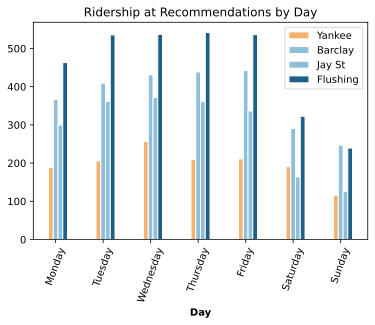

In [304]:
#All recs minus Union by days -- Bar Graph

barWidth = 0.1
 
# set height of bar
bars1 = yankee_days
bars2 = barclay_days
bars3 = jayst_days
bars4 = flushing_days


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
plt.bar(r1, bars1, color='#f6b26bff', width=barWidth, edgecolor='white', label='Yankee')
plt.bar(r2, bars2, color='#8ebed9ff', width=barWidth, edgecolor='white', label='Barclay')
plt.bar(r3, bars3, color='#8ebed9ff', width=barWidth, edgecolor='white', label='Jay St')
plt.bar(r4, bars4, color='#1e5f85ff', width=barWidth, edgecolor='white', label='Flushing')

 
# Add xticks on the middle of the group bars
plt.xlabel('Day', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], cats, rotation=70)

plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\multi_graph_no_union.png',kind='png')   
# Create legend & Show graphic
plt.title('Ridership at Recommendations by Day')
plt.legend()
plt.show()

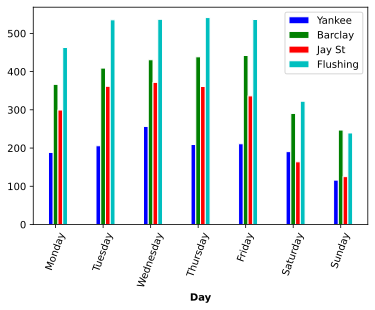

In [295]:
#All recs by station, then by days - Bar Graph

barWidth = 0.1
 
# set height of bar
bars1 = yankee_days
bars2 = barclay_days
bars3 = jayst_days
bars4 = flushing_days


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='Yankee')
plt.bar(r2, bars2, color='g', width=barWidth, edgecolor='white', label='Barclay')
plt.bar(r3, bars3, color='r', width=barWidth, edgecolor='white', label='Jay St')
plt.bar(r4, bars4, color='c', width=barWidth, edgecolor='white', label='Flushing')

 
# Add xticks on the middle of the group bars
plt.xlabel('Day', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], cats, rotation=70)
  
# Create legend & Show graphic
plt.legend()
plt.show()

ConversionError: Failed to convert value(s) to axis units: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

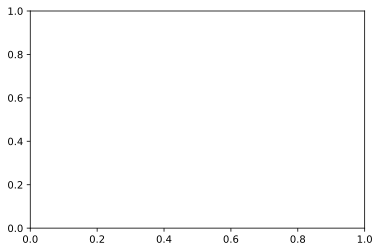

In [292]:
yankee_days = df1.loc[df1['STATION']=='161/YANKEE STAD'].groupby('Day')['Total Flow'].sum().reindex(cats)/1000
barclay_days = df1.loc[df1['STATION']=='ATL AV-BARCLAY'].groupby('Day')['Total Flow'].sum().reindex(cats)/1000
plt.xticks(cats,rotation=70)
plt.title('Riders By Day and Station')
plt.tight_layout()

plt.bar(cats,barclay_days.round(1))
plt.bar(cats,yankee_days.round(1))
plt.ylabel('Riders (thousand)')
plt.show

In [144]:
#Find daily sum for each STATION for each day of the week
df1_daily = df1.groupby(['STATION','DATE'],as_index=False)['Total Flow'].sum()
df1_daily.head(20)

,STATION,DATE,Total Flow
0,1 AV,04/27/2019,15989.676471
1,1 AV,04/28/2019,12444.000000
2,1 AV,04/29/2019,36454.000000
3,1 AV,04/30/2019,39009.000000
4,1 AV,05/01/2019,40345.000000
5,1 AV,05/02/2019,40741.000000
6,1 AV,05/03/2019,42397.000000
7,1 AV,05/04/2019,17728.000000
8,1 AV,05/05/2019,13728.000000
9,1 AV,05/06/2019,36691.000000


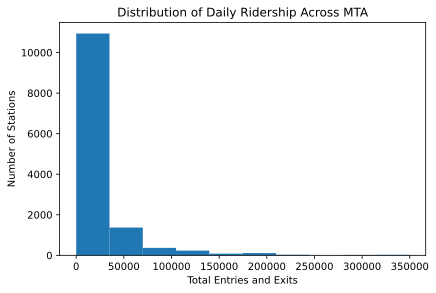

In [180]:
plt.hist(df1_daily['Total Flow'])
plt.title('Distribution of Daily Ridership Across MTA')
plt.tight_layout()
plt.xlabel('Total Entries and Exits')
plt.ylabel('Number of Stations')
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_daily_dist.svg',kind='svg')
plt.show()
#box and whisker to see that there are outliers as recommendations

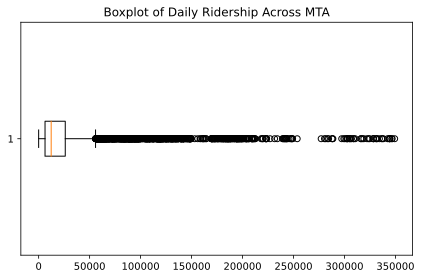

In [186]:
plt.boxplot(df1_daily['Total Flow'],vert=False)
plt.title('Boxplot of Daily Ridership Across MTA')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_daily_boxplot.svg',kind='svg')
plt.show()

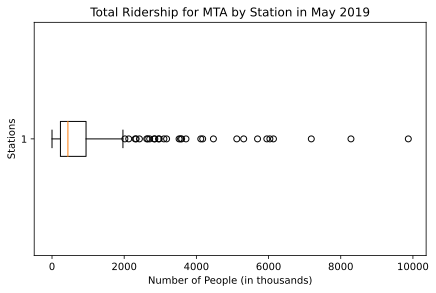

In [192]:
plt.boxplot(ridership,vert=False, meanline=True)
plt.title('Total Ridership for MTA by Station in May 2019')
plt.tight_layout()
plt.ylabel('Stations')
plt.xlabel('Number of People (in thousands)')
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_total_boxplot.svg',kind='svg')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

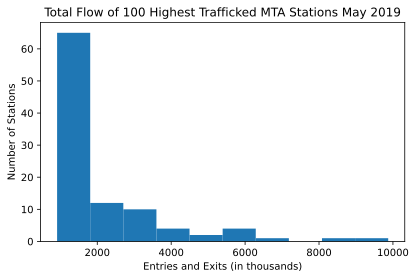

In [147]:
ridership = df1.groupby(['STATION'])['Total Flow'].sum()/1000
top_100 = ridership.sort_values(ascending=False).round(0).head(100)

plt.hist(top_100)
plt.title('Total Flow of 100 Highest Trafficked MTA Stations May 2019')
plt.xlabel('Entries and Exits (in thousands)')
plt.ylabel('Number of Stations')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_top100_dist.svg',kind='svg')
plt.show
#Try as box plot

In [166]:
top_20 = ridership.sort_values(ascending=False).reset_index().head(20)
top_20

,STATION,Total Flow
0,34 ST-PENN STA,9872.320102
1,GRD CNTRL-42 ST,8283.118839
2,34 ST-HERALD SQ,7184.260678
3,14 ST-UNION SQ,6136.191787
4,TIMES SQ-42 ST,6036.652416
5,23 ST,5951.988277
6,42 ST-PORT AUTH,5694.885440
7,FULTON ST,5310.743000
8,86 ST,5119.460362
9,125 ST,4472.492055


<function matplotlib.pyplot.show(*args, **kw)>

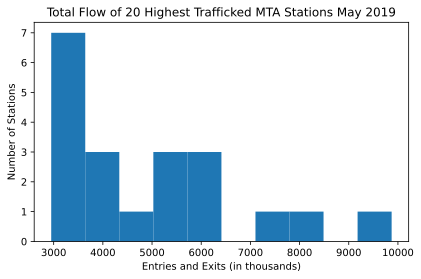

In [149]:
plt.hist(top_20)
plt.title('Total Flow of 20 Highest Trafficked MTA Stations May 2019')
plt.xlabel('Entries and Exits (in thousands)')
plt.ylabel('Number of Stations')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_top20.svg',kind='svg')
plt.show


,STATION,Total Flow
0,34 ST-PENN STA,1443.772924
1,GRD CNTRL-42 ST,1243.834501
2,34 ST-HERALD SQ,1015.021407
3,23 ST,849.403453
4,14 ST-UNION SQ,842.755000
5,TIMES SQ-42 ST,816.606066
6,42 ST-PORT AUTH,812.572973
7,FULTON ST,800.483000
8,86 ST,724.892182
9,125 ST,629.671893


In [268]:
ridership = df1.groupby(['STATION'])['Total Flow'].sum()/1000
top_10 = ridership.sort_values(ascending=False).reset_index().head(10)
ridership

STATION
1 AV               1109.516676
103 ST             1626.619529
103 ST-CORONA      1083.448794
104 ST              207.297006
110 ST              627.729088
                      ...     
WOODLAWN            264.402765
WORLD TRADE CTR     972.599442
WTC-CORTLANDT       717.227941
YORK ST             581.951176
ZEREGA AV           152.931265
Name: Total Flow, Length: 378, dtype: float64

[7500, 2500, 5000, 1500] <class 'list'>


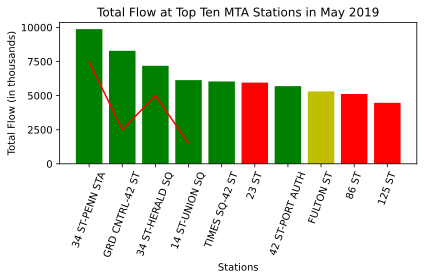

In [152]:
ticks_x = np.linspace(0,9,10)
ticks_y = np.linspace(0,10000,5)
plt.figure(figsize=[6,4])
plt.bar(top_10['STATION'],top_10['Total Flow'],color=['g','g','g','g','g','r','g','y','r','r'])
plt.title('Total Flow at Top Ten MTA Stations in May 2019')
plt.xlabel('Stations')
plt.ylabel('Total Flow (in thousands)')
plt.xticks(ticks_x,top_10['STATION'],rotation=70)
plt.yticks(ticks_y)
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_top10_colorcoded.svg',kind='svg')
plt.show

data_list = [7500,2500,5000,1500]
print(data_list, type(data_list))
plt.plot(data_list,'r');
#Second y-axis with percetage of women or above income threshold

<function matplotlib.pyplot.show(*args, **kw)>

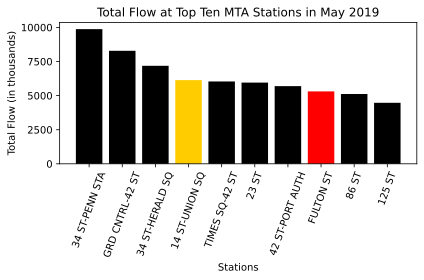

In [183]:
ticks_x = np.linspace(0,9,10)
ticks_y = np.linspace(0,10000,5)
plt.figure(figsize=[6,4])
plt.bar(top_10['STATION'],top_10['Total Flow'],color=['k','k','k','#ffcc00','k','k','k','r','k','k'])
plt.title('Total Flow at Top Ten MTA Stations in May 2019')
plt.xlabel('Stations')
plt.ylabel('Total Flow (in thousands)')
plt.xticks(ticks_x,top_10['STATION'],rotation=70)
plt.yticks(ticks_y)
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_top20_colorcoded.svg',kind='svg')
plt.show


In [153]:
ridership = ridership.reset_index()
ridership.head()

,STATION,Total Flow
0,1 AV,1109.516676
1,103 ST,1626.619529
2,103 ST-CORONA,1083.448794
3,104 ST,207.297006
4,110 ST,627.729088


In [154]:
sum = ridership['Total Flow'].sum()
ridership.shape

(378, 2)

In [94]:
sum*1000

316085932.8091887

In [155]:
ridership['Percentage of Total Flow'] = (ridership['Total Flow']*100/sum).round(2)
ridership.sort_values(['Percentage of Total Flow'],ascending=False).head(60)

,STATION,Total Flow,Percentage of Total Flow
61,34 ST-PENN STA,9872.320102,3.12
232,GRD CNTRL-42 ST,8283.118839,2.62
59,34 ST-HERALD SQ,7184.260678,2.27
14,14 ST-UNION SQ,6136.191787,1.94
352,TIMES SQ-42 ST,6036.652416,1.91
46,23 ST,5951.988277,1.88
68,42 ST-PORT AUTH,5694.885440,1.80
225,FULTON ST,5310.743000,1.68
110,86 ST,5119.460362,1.62
9,125 ST,4472.492055,1.41


In [96]:
ridership.sort_values(['Percentage of Total Flow'],ascending=False)['Percentage of Total Flow'].head(5).sum()

11.86

In [63]:
station_zips = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
station_zips.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN


In [111]:
#When stations are divided to correctly represent the geography of New York, 

#Not ever row represents a new station, have to see if LINENAMEs correspond to new stations.
#e.g.: 34 ST-PENN STA is all one station-complex, BUT:
#Fulton is two stations, 125 is 4, Canal is 3, 23 St is 5 86 ST is 5

#Use as a check against top list of stations, to make sure that none are being overvalued

df1[(df1['STATION']=='23 ST')|
    (df1['STATION']=='86 ST')|
    (df1['STATION']=='FULTON ST')|
    (df1['STATION']=='125 ST')|
    (df1['STATION']=='CANAL ST')|
    (df1['STATION']=='34 ST-PENN STA')
   ].groupby(['STATION','DIVISION','LINENAME'])['Total Flow'].sum()*100/1000/sum

STATION         DIVISION  LINENAME
125 ST          IND       ACBD        0.545303
                IRT       1           0.158912
                          23          0.217464
                          456         0.493282
23 ST           BMT       NRW         0.347372
                IND       CE          0.381687
                          FM          0.418483
                IRT       1           0.254489
                          6           0.480997
34 ST-PENN STA  IND       ACE         1.535978
                IRT       123         0.666932
                          123ACE      0.920392
86 ST           BMT       N           0.042936
                          R           0.171030
                IND       BC          0.197753
                IRT       1           0.361913
                          456         0.846011
CANAL ST        BMT       JNQRZ6W     0.826412
                IND       ACE         0.376570
                IRT       1           0.117742
FULTON ST       BMT      

In [253]:
#wtc_total = df1.loc[df1['STATION']=='FLUSHING-MAIN'].groupby('Day')['Total Flow'].sum()
#wtc_total

In [272]:
df_riders = ridership.sort_values(ascending=False).reset_index()
df_our_five = df_riders.loc[(df_riders['STATION']=='161/YANKEE STAD') |
                            (df_riders['STATION']=='ATL AV-BARCLAY') |
                            (df_riders['STATION']=='JAY ST-METROTEC') |
                            (df_riders['STATION']=='14 ST-UNION SQ') |
                            (df_riders['STATION']=='FLUSHING-MAIN') ]
df_our_five

,STATION,Total Flow
3,14 ST-UNION SQ,6136.191787
16,FLUSHING-MAIN,3175.033353
24,ATL AV-BARCLAY,2625.144429
29,JAY ST-METROTEC,2019.450471
52,161/YANKEE STAD,1378.193338


<function matplotlib.pyplot.show(*args, **kw)>

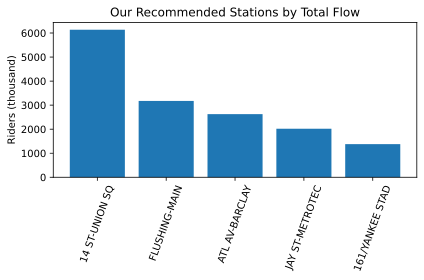

In [274]:
plt.bar(df_our_five['STATION'],df_our_five['Total Flow'].round(1))
plt.xticks(df_our_five['STATION'],rotation=70)
plt.title('Our Recommended Stations by Total Flow')
plt.ylabel('Riders (thousand)')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\our_recommendations.svg',kind='svg')
plt.show

In [ ]:
spacing = np.linspace(0,4,5)
plt.bar(df1['STATION'],df1['Total Flow'])
plt.xticks(spacing, rotation=70)
plt.title('Total traffic at selected stations May 2019')
plt.xlabel('Stations')
plt.ylabel('Thousands')
plt.tight_layout()
plt.show;

In [ ]:
ridership = df1[df1['Day']=='Monday'].groupby(['STATION'])['Total Flow'].sum()/1000
monday_top_10 = ridership.sort_values(ascending=False).reset_index().head(10)
monday_top_10